In [ ]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
from torchvision import models

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
class ImageDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None, max_attempts=5):
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.max_attempts = max_attempts  # Limit attempts to avoid infinite loops

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        attempts = 0
        while attempts < self.max_attempts:
            try:
                # Get image path
                img_name = os.path.join(self.img_dir, f"{int(self.annotations.iloc[idx]['imagefile']):06}.jpg")

                image = Image.open(img_name).convert("RGB")

                # Get label
                label = torch.tensor(int(self.annotations.iloc[idx]['ID']))

                # Apply transformation if available
                if self.transform:
                    image = self.transform(image)

                return image, label

            except FileNotFoundError:
                # Handle missing file and attempt to move to the next image
                print(f"File not found: {self.annotations.iloc[idx]['imagefile']}. Skipping...")
                idx = (idx + 1) % len(self.annotations)  # Move to the next image
                attempts += 1  # Count this as a failed attempt

        # If the loop exceeds max_attempts, raise an error
        raise RuntimeError(f"Exceeded maximum attempts to load valid images. Check your dataset.")

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.ColorJitter(contrast=5, brightness=5),  # Adjust contrast and brightness
    # transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),  # Apply Gaussian blur
    transforms.ToTensor(),
   # transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3)), # Resize images to the size expected by ResNet

    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Standard normalization for ImageNet
])


In [ ]:
import os
import csv
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
# Mount Google Drive (if using Google Colab)
from google.colab import drive
drive.mount('/content/mydrive')

# Define the paths to the folders and CSV file
drive_path = '/content/mydrive/MyDrive/'  # Modify as needed
check_folder = os.path.join(drive_path, 'check')
plainsing_folder = os.path.join(drive_path, 'plainsing')
csv_file_path = os.path.join(check_folder, 'idplainsing_mapped.csv')

batch_size= 20
num_workers = 0

# Specify the root directory for images and the CSV file containing class labels and filenames
root_dir = '/content/mydrive/MyDrive/check/plainsing'  # Change this to your directory
csv_file = '/content/mydrive/MyDrive/check/idplainsing_mapped.csv'  # CSV file containing ids (labels) and image filenames

valid_size = 0.2

csv_file =csv_file_path  # Path to CSV with image file names and labels
img_dir = plainsing_folder  # Path to image folder
dataset = ImageDataset(csv_file, root_dir, transform=transform)

# Split dataset into validation and test sets
train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size  # 20% for testing
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
num_train = len(train_dataset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
    num_workers=num_workers)

Drive already mounted at /content/mydrive; to attempt to forcibly remount, call drive.mount("/content/mydrive", force_remount=True).


In [ ]:
batch_size = 16
#dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [ ]:
num_classes = 28 # 107 unique tiger ids



In [ ]:
# # images, labels = next(iter(dataloader))
# # print(images.shape, labels.shap
# dataiter = iter(train_loader)
# data = next(dataiter)
# images, labels = data
# print(images.shape, labels.shape)

In [ ]:
class iAdam(torch.optim.Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0.1, lambda_func=lambda t: 1.0):
        defaults = {'lr': lr, 'betas': betas, 'eps': eps, 'weight_decay': weight_decay, 'lambda_func': lambda_func}
        super(iAdam, self).__init__(params, defaults)
        # Initialize state for each parameter
        for p in self.param_groups[0]['params']:
            self.state[p] = {
                'step': 0,
                'exp_avg': torch.zeros_like(p.data),
                'exp_avg_sq': torch.zeros_like(p.data),
            }

    def step(self):
        for group in self.param_groups:
            lr = group['lr']
            beta1, beta2 = group['betas']
            eps = group['eps']
            weight_decay = group['weight_decay']  # Fetch weight decay
            lambda_func = group['lambda_func']

            for p in group['params']:
                if p.grad is None:
                    continue

                state = self.state[p]
                state['step'] += 1
                exp_avg = state['exp_avg']
                exp_avg_sq = state['exp_avg_sq']

                # Calculate lambda_t and check for validity
                lambda_t = torch.tensor(lambda_func(state['step']), dtype=torch.float32)
                if torch.isnan(lambda_t) or torch.isinf(lambda_t):
                    lambda_t = torch.tensor(1.0)  # Default to 1.0 if invalid

                # Apply weight decay (L2 regularization)
                if weight_decay > 0:
                    p.grad.data.add_(weight_decay * p.data)

                # Compute the weight penalty
                weight_penalty = lambda_t * p.data * 0.000001

                # Compute the adjusted gradient
                grad = p.grad.data - exp_avg + weight_penalty
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(p.grad.data, p.grad.data, value=1 - beta2)

                # Compute bias-corrected averages
                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']

                # Compute the step size and denominator
                step_size = lr / bias_correction1
                denom = exp_avg_sq.sqrt().div(bias_correction2).add_(eps)

                # Update parameters
                p.data.addcdiv_(exp_avg, denom, value=-step_size)

                # Optionally apply gradient clipping before updating parameters
                torch.nn.utils.clip_grad_norm_([p], max_norm=1.0)


# **[ALEXNET Code training](https://)**

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1 finished, Train Loss: 2.4530
Epoch 1 finished, Validation Loss: 1.4591
Best model saved with validation loss: 1.4591
Epoch 2 finished, Train Loss: 0.9026
Epoch 2 finished, Validation Loss: 1.1062
Best model saved with validation loss: 1.1062
Epoch 3 finished, Train Loss: 0.6589
Epoch 3 finished, Validation Loss: 1.1529
Epoch 4 finished, Train Loss: 0.6983
Epoch 4 finished, Validation Loss: 1.1542
Epoch 5 finished, Train Loss: 0.8192
Epoch 5 finished, Validation Loss: 0.9374
Best model saved with validation loss: 0.9374
Epoch 6 finished, Train Loss: 1.1248
Epoch 6 finished, Validation Loss: 1.1984
Epoch 7 finished, Train Loss: 1.0171
Epoch 7 finished, Validation Loss: 1.1232
Epoch 8 finished, Train Loss: 1.0919
Epoch 8 finished, Validation Loss: 1.1872
Epoch 9 finished, Train Loss: 0.9904
Epoch 9 finished, Validation Loss: 1.0427
Epoch 10 finished, Train Loss: 0.9978
Epoch 10 finished, Validation Loss: 1.7012
Epoch 11 finished, Train Loss: 1.0510
Epoch 11 finished, Validation Lo

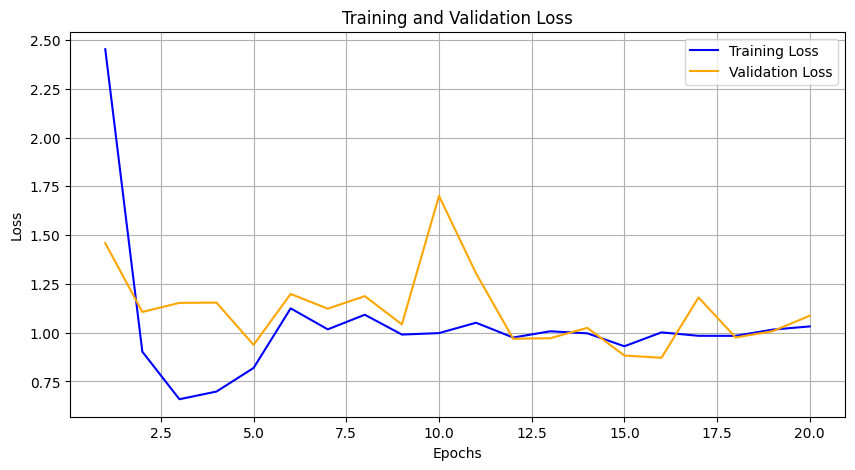

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import pandas as pd
import matplotlib.pyplot as plt
import os

# Check if CUDA is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the pre-trained AlexNet model
model = models.alexnet(pretrained=True)

# Freeze all layers except the final fully connected layer
for param in model.features.parameters():
    param.requires_grad = False  # Freeze feature extraction layers

# Modify the final fully connected layer for 28 classes
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 28)

# Move the model to the GPU
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Suitable for multi-class classification
optimizer = iAdam(model.parameters(), lr=0.001)  # Adam optimizer

num_epochs = 20
train_loss_list = []  # To store training loss
val_loss_list = []    # To store validation loss
best_val_loss = float('inf')  # Initialize with infinity to track the best validation loss
best_model_path = "AlexNetbest_model.pth"  # File to store the best model

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_train_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        # Move images and labels to GPU
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()  # Clear gradients
        loss.backward()        # Backpropagation
        optimizer.step()       # Update weights

        running_train_loss += loss.item()

    epoch_train_loss = running_train_loss / len(train_loader)
    train_loss_list.append((epoch + 1, epoch_train_loss))  # Store epoch number and training loss
    print(f'Epoch {epoch+1} finished, Train Loss: {epoch_train_loss:.4f}')

    # Validation phase
    model.eval()
    running_val_loss = 0.0

    with torch.no_grad():
        for images, labels in valid_loader:  # Use your validation loader
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

    epoch_val_loss = running_val_loss / len(valid_loader)
    val_loss_list.append((epoch + 1, epoch_val_loss))  # Store epoch number and validation loss
    print(f'Epoch {epoch+1} finished, Validation Loss: {epoch_val_loss:.4f}')

    # Save the model if it has the best validation loss so far
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model.state_dict(), best_model_path)  # Save the model's state dictionary
        print(f"Best model saved with validation loss: {best_val_loss:.4f}")

# Combine and save losses to a CSV file
loss_data = [(epoch, train_loss, val_loss) for (epoch, train_loss), (_, val_loss) in zip(train_loss_list, val_loss_list)]
df = pd.DataFrame(loss_data, columns=['Epoch', 'Train Loss', 'Validation Loss'])
df.to_csv('lossesAlexNet.csv', index=False)

print("Losses saved to 'losses.csv'.")

# Plotting the losses
epochs = [epoch for epoch, _ in train_loss_list]
train_losses = [loss for _, loss in train_loss_list]
val_losses = [loss for _, loss in val_loss_list]

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss', color='blue')
plt.plot(epochs, val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.savefig('loss_plotAlexNet.png')  # Save the plot as a PNG file
plt.show()  # Display the plot


# **AlexNet Testing**

In [ ]:
import torch
import numpy as np
from sklearn.metrics import average_precision_score
from tqdm import tqdm

# Function to calculate mAP (mean Average Precision)
def calculate_map(all_labels, all_scores, num_classes):
    mAP_scores = []
    for c in range(num_classes):
        true_labels = (all_labels == c).astype(int)
        pred_scores = all_scores[:, c]  # Scores for class c

        # Handle case where there are no positive samples
        if true_labels.sum() == 0:
            mAP_scores.append(0.0)
            continue

        ap = average_precision_score(true_labels, pred_scores)
        mAP_scores.append(ap)

    mAP = np.mean(mAP_scores)
    return mAP

# Function to evaluate the model
def evaluate_model(model, test_loader, num_classes, model_path=None):
    # Load the best model if the path is provided
    if model_path is not None:
        print(f"Loading the best model from {model_path}")
        model.load_state_dict(torch.load(model_path))
        model = model.to(device)

    model.eval()  # Set model to evaluation mode
    top1_correct = 0
    top5_correct = 0
    total = 0
    all_labels = []
    all_preds = []
    all_scores = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images = images.to(device)  # Move images to the GPU
            labels = labels.to(device)  # Move labels to the GPU

            outputs = model(images)  # Forward pass

            # Get predicted class probabilities
            pred_scores = torch.softmax(outputs, dim=1)  # Shape: (batch_size, num_classes)

            # Get class predictions
            _, predicted = torch.max(outputs, 1)  # Shape: (batch_size,)

            # Top-1 accuracy
            top1_correct += (predicted == labels).sum().item()
            # Top-5 accuracy
            _, top5_pred = torch.topk(outputs, 5, dim=1)
            top5_correct += (top5_pred == labels.view(-1, 1).expand_as(top5_pred)).sum().item()

            total += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_scores.append(pred_scores.cpu().numpy())  # Append the scores

    # Calculate accuracies
    top1_accuracy = (top1_correct / total) * 100
    top5_accuracy = (top5_correct / total) * 100

    # Concatenate all predicted scores into a 2D array
    all_scores = np.concatenate(all_scores)  # Shape: (num_samples, num_classes)

    # Calculate mean Average Precision (mAP)
    mAP = calculate_map(np.array(all_labels), all_scores, num_classes)

    print(f'Top-1 Accuracy: {top1_accuracy:.4f}')
    print(f'Top-5 Accuracy: {top5_accuracy:.4f}')
    print(f'mAP: {mAP:.4f}')

    return {
        'Top-1 Accuracy': top1_accuracy,
        'Top-5 Accuracy': top5_accuracy,
        'mAP': mAP,
    }

# Example usage
best_model_path = 'AlexNetbest_model.pth'  # Path where the best model is saved
results = evaluate_model(model, test_loader, num_classes=28, model_path=best_model_path)

# Print evaluation results
for metric, value in results.items():
    print(f'{metric}: {value:.4f}')


Loading the best model from AlexNetbest_model.pth


<ipython-input-27-60b52088d642>:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
100%|██████████| 11/11 [00:01<00:00,  7.15it/

Top-1 Accuracy: 75.5869
Top-5 Accuracy: 96.2441
mAP: 0.8291
Top-1 Accuracy: 75.5869
Top-5 Accuracy: 96.2441
mAP: 0.8291


## **ResNet18 Training**

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1 finished, Train Loss: 3.5307
Epoch 1 finished, Validation Loss: 3.5798
Best model saved with validation loss: 3.5798
Epoch 2 finished, Train Loss: 3.1820
Epoch 2 finished, Validation Loss: 3.3927
Best model saved with validation loss: 3.3927
Epoch 3 finished, Train Loss: 2.9520
Epoch 3 finished, Validation Loss: 3.1827
Best model saved with validation loss: 3.1827
Epoch 4 finished, Train Loss: 2.7690
Epoch 4 finished, Validation Loss: 3.0341
Best model saved with validation loss: 3.0341
Epoch 5 finished, Train Loss: 2.5941
Epoch 5 finished, Validation Loss: 2.8615
Best model saved with validation loss: 2.8615
Epoch 6 finished, Train Loss: 2.3459
Epoch 6 finished, Validation Loss: 2.7199
Best model saved with validation loss: 2.7199
Epoch 7 finished, Train Loss: 2.1796
Epoch 7 finished, Validation Loss: 2.4536
Best model saved with validation loss: 2.4536
Epoch 8 finished, Train Loss: 1.9998
Epoch 8 finished, Validation Loss: 2.3627
Best model saved with validation loss: 2.3627


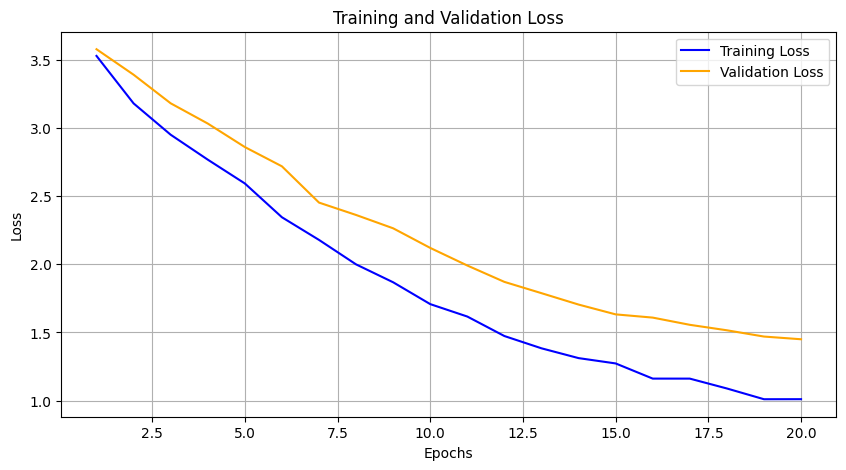

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import pandas as pd
import matplotlib.pyplot as plt
import os

# Check if CUDA is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the pre-trained ResNet model
model = models.resnet18(pretrained=True)  # You can also use resnet50 or resnet101, etc.

# Freeze all convolutional layers (i.e., feature extractor)
for param in model.parameters():
    param.requires_grad = False

# Modify the final fully connected layer for 28 output classes
num_classes = 28
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move the model to the GPU
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Suitable for multi-class classification
optimizer = iAdam(model.parameters(), lr=0.001)  # Adam optimizer

num_epochs = 20
train_loss_list = []  # To store training loss
val_loss_list = []    # To store validation loss
best_val_loss = float('inf')  # Initialize with infinity to track the best validation loss
best_model_path = "ResNetbest_model.pth"  # File to store the best model

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_train_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        # Move images and labels to GPU
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()  # Clear gradients
        loss.backward()        # Backpropagation
        optimizer.step()       # Update weights

        running_train_loss += loss.item()

    epoch_train_loss = running_train_loss / len(train_loader)
    train_loss_list.append((epoch + 1, epoch_train_loss))  # Store epoch number and training loss
    print(f'Epoch {epoch+1} finished, Train Loss: {epoch_train_loss:.4f}')

    # Validation phase
    model.eval()
    running_val_loss = 0.0

    with torch.no_grad():
        for images, labels in valid_loader:  # Use your validation loader
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

    epoch_val_loss = running_val_loss / len(valid_loader)
    val_loss_list.append((epoch + 1, epoch_val_loss))  # Store epoch number and validation loss
    print(f'Epoch {epoch+1} finished, Validation Loss: {epoch_val_loss:.4f}')

    # Save the model if it has the best validation loss so far
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model.state_dict(), best_model_path)  # Save the model's state dictionary
        print(f"Best model saved with validation loss: {best_val_loss:.4f}")

# Combine and save losses to a CSV file
loss_data = [(epoch, train_loss, val_loss) for (epoch, train_loss), (_, val_loss) in zip(train_loss_list, val_loss_list)]
df = pd.DataFrame(loss_data, columns=['Epoch', 'Train Loss', 'Validation Loss'])
df.to_csv('lossesResNet.csv', index=False)

print("Losses saved to 'losses.csv'.")

# Plotting the losses
epochs = [epoch for epoch, _ in train_loss_list]
train_losses = [loss for _, loss in train_loss_list]
val_losses = [loss for _, loss in val_loss_list]

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss', color='blue')
plt.plot(epochs, val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.savefig('loss_plotResnet.png')  # Save the plot as a PNG file
plt.show()  # Display the plot


# **ResNet Testing**

In [ ]:
import torch
import numpy as np
from sklearn.metrics import average_precision_score
from tqdm import tqdm

# Function to calculate mAP (mean Average Precision)
def calculate_map(all_labels, all_scores, num_classes):
    mAP_scores = []
    for c in range(num_classes):
        true_labels = (all_labels == c).astype(int)
        pred_scores = all_scores[:, c]  # Scores for class c

        # Handle case where there are no positive samples
        if true_labels.sum() == 0:
            mAP_scores.append(0.0)
            continue

        ap = average_precision_score(true_labels, pred_scores)
        mAP_scores.append(ap)

    mAP = np.mean(mAP_scores)
    return mAP

# Function to evaluate the model
def evaluate_model(model, test_loader, num_classes, model_path=None):
    # Load the best model if the path is provided
    if model_path is not None:
        print(f"Loading the best model from {model_path}")
        model.load_state_dict(torch.load(model_path))
        model = model.to(device)

    model.eval()  # Set model to evaluation mode
    top1_correct = 0
    top5_correct = 0
    total = 0
    all_labels = []
    all_preds = []
    all_scores = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images = images.to(device)  # Move images to the GPU
            labels = labels.to(device)  # Move labels to the GPU

            outputs = model(images)  # Forward pass

            # Get predicted class probabilities
            pred_scores = torch.softmax(outputs, dim=1)  # Shape: (batch_size, num_classes)

            # Get class predictions
            _, predicted = torch.max(outputs, 1)  # Shape: (batch_size,)

            # Top-1 accuracy
            top1_correct += (predicted == labels).sum().item()
            # Top-5 accuracy
            _, top5_pred = torch.topk(outputs, 5, dim=1)
            top5_correct += (top5_pred == labels.view(-1, 1).expand_as(top5_pred)).sum().item()

            total += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_scores.append(pred_scores.cpu().numpy())  # Append the scores

    # Calculate accuracies
    top1_accuracy = (top1_correct / total) * 100
    top5_accuracy = (top5_correct / total) * 100

    # Concatenate all predicted scores into a 2D array
    all_scores = np.concatenate(all_scores)  # Shape: (num_samples, num_classes)

    # Calculate mean Average Precision (mAP)
    mAP = calculate_map(np.array(all_labels), all_scores, num_classes)

    print(f'Top-1 Accuracy: {top1_accuracy:.4f}')
    print(f'Top-5 Accuracy: {top5_accuracy:.4f}')
    print(f'mAP: {mAP:.4f}')

    return {
        'Top-1 Accuracy': top1_accuracy,
        'Top-5 Accuracy': top5_accuracy,
        'mAP': mAP,
    }

# Example usage
best_model_path = 'ResNetbest_model.pth'  # Path where the best model is saved
results = evaluate_model(model, test_loader, num_classes=28, model_path=best_model_path)

# Print evaluation results
for metric, value in results.items():
    print(f'{metric}: {value:.4f}')


<ipython-input-29-b0828c947b31>:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Loading the best model from ResNetbest_model.pth


100%|██████████| 11/11 [00:01<00:00,  6.49it/s]

Top-1 Accuracy: 61.9718
Top-5 Accuracy: 92.4883
mAP: 0.7167
Top-1 Accuracy: 61.9718
Top-5 Accuracy: 92.4883
mAP: 0.7167


# **VGGNet16 Training**

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1 finished, Train Loss: 2.7063
Epoch 1 finished, Validation Loss: 1.8511
Best model saved with validation loss: 1.8511
Epoch 2 finished, Train Loss: 1.2597
Epoch 2 finished, Validation Loss: 1.0757
Best model saved with validation loss: 1.0757
Epoch 3 finished, Train Loss: 1.0105
Epoch 3 finished, Validation Loss: 1.0030
Best model saved with validation loss: 1.0030
Epoch 4 finished, Train Loss: 1.0396
Epoch 4 finished, Validation Loss: 1.1526
Epoch 5 finished, Train Loss: 0.9593
Epoch 5 finished, Validation Loss: 0.9906
Best model saved with validation loss: 0.9906
Epoch 6 finished, Train Loss: 0.9645
Epoch 6 finished, Validation Loss: 1.1100
Epoch 7 finished, Train Loss: 0.8887
Epoch 7 finished, Validation Loss: 1.1687
Epoch 8 finished, Train Loss: 0.8301
Epoch 8 finished, Validation Loss: 1.0407
Epoch 9 finished, Train Loss: 0.8642
Epoch 9 finished, Validation Loss: 1.0754
Epoch 10 finished, Train Loss: 0.8483
Epoch 10 finished, Validation Loss: 0.9602
Best model saved with va

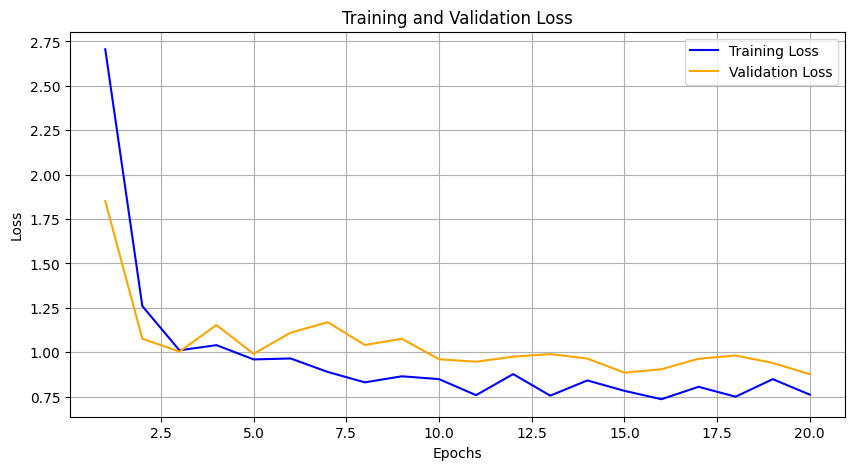

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import pandas as pd
import matplotlib.pyplot as plt
import os

# Check if CUDA is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the pre-trained VGG16 model
model = models.vgg16(pretrained=True)  # You can also use vgg19

# Freeze all layers except the classifier (fully connected layers)
for param in model.features.parameters():  # Freeze feature extractor (convolutional layers)
    param.requires_grad = False

# Modify the final classifier layer for 28 output classes
num_classes = 28
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

# Move the model to the GPU
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Suitable for multi-class classification
optimizer = iAdam(model.parameters(), lr=0.001)  # Adam optimizer

num_epochs = 20
train_loss_list = []  # To store training loss
val_loss_list = []    # To store validation loss
best_val_loss = float('inf')  # Initialize with infinity to track the best validation loss
best_model_path = "VGGNetbest_model.pth"  # File to store the best model

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_train_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        # Move images and labels to GPU
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()  # Clear gradients
        loss.backward()        # Backpropagation
        optimizer.step()       # Update weights

        running_train_loss += loss.item()

    epoch_train_loss = running_train_loss / len(train_loader)
    train_loss_list.append((epoch + 1, epoch_train_loss))  # Store epoch number and training loss
    print(f'Epoch {epoch+1} finished, Train Loss: {epoch_train_loss:.4f}')

    # Validation phase
    model.eval()
    running_val_loss = 0.0

    with torch.no_grad():
        for images, labels in valid_loader:  # Use your validation loader
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

    epoch_val_loss = running_val_loss / len(valid_loader)
    val_loss_list.append((epoch + 1, epoch_val_loss))  # Store epoch number and validation loss
    print(f'Epoch {epoch+1} finished, Validation Loss: {epoch_val_loss:.4f}')

    # Save the model if it has the best validation loss so far
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model.state_dict(), best_model_path)  # Save the model's state dictionary
        print(f"Best model saved with validation loss: {best_val_loss:.4f}")

# Combine and save losses to a CSV file
loss_data = [(epoch, train_loss, val_loss) for (epoch, train_loss), (_, val_loss) in zip(train_loss_list, val_loss_list)]
df = pd.DataFrame(loss_data, columns=['Epoch', 'Train Loss', 'Validation Loss'])
df.to_csv('lossesVGGNet.csv', index=False)

print("Losses saved to 'losses.csv'.")

# Plotting the losses
epochs = [epoch for epoch, _ in train_loss_list]
train_losses = [loss for _, loss in train_loss_list]
val_losses = [loss for _, loss in val_loss_list]

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss', color='blue')
plt.plot(epochs, val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.savefig('loss_plotVGGnet.png')  # Save the plot as a PNG file
plt.show()  # Display the plot


# **VGGNet16 testing**`

In [ ]:
import torch
import numpy as np
from sklearn.metrics import average_precision_score
from tqdm import tqdm

# Function to calculate mAP (mean Average Precision)
def calculate_map(all_labels, all_scores, num_classes):
    mAP_scores = []
    for c in range(num_classes):
        true_labels = (all_labels == c).astype(int)
        pred_scores = all_scores[:, c]  # Scores for class c

        # Handle case where there are no positive samples
        if true_labels.sum() == 0:
            mAP_scores.append(0.0)
            continue

        ap = average_precision_score(true_labels, pred_scores)
        mAP_scores.append(ap)

    mAP = np.mean(mAP_scores)
    return mAP

# Function to evaluate the model
def evaluate_model(model, test_loader, num_classes, model_path=None):
    # Load the best model if the path is provided
    if model_path is not None:
        print(f"Loading the best model from {model_path}")
        model.load_state_dict(torch.load(model_path))
        model = model.to(device)

    model.eval()  # Set model to evaluation mode
    top1_correct = 0
    top5_correct = 0
    total = 0
    all_labels = []
    all_preds = []
    all_scores = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images = images.to(device)  # Move images to the GPU
            labels = labels.to(device)  # Move labels to the GPU

            outputs = model(images)  # Forward pass

            # Get predicted class probabilities
            pred_scores = torch.softmax(outputs, dim=1)  # Shape: (batch_size, num_classes)

            # Get class predictions
            _, predicted = torch.max(outputs, 1)  # Shape: (batch_size,)

            # Top-1 accuracy
            top1_correct += (predicted == labels).sum().item()
            # Top-5 accuracy
            _, top5_pred = torch.topk(outputs, 5, dim=1)
            top5_correct += (top5_pred == labels.view(-1, 1).expand_as(top5_pred)).sum().item()

            total += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_scores.append(pred_scores.cpu().numpy())  # Append the scores

    # Calculate accuracies
    top1_accuracy = (top1_correct / total) * 100
    top5_accuracy = (top5_correct / total) * 100

    # Concatenate all predicted scores into a 2D array
    all_scores = np.concatenate(all_scores)  # Shape: (num_samples, num_classes)

    # Calculate mean Average Precision (mAP)
    mAP = calculate_map(np.array(all_labels), all_scores, num_classes)

    print(f'Top-1 Accuracy: {top1_accuracy:.4f}')
    print(f'Top-5 Accuracy: {top5_accuracy:.4f}')
    print(f'mAP: {mAP:.4f}')

    return {
        'Top-1 Accuracy': top1_accuracy,
        'Top-5 Accuracy': top5_accuracy,
        'mAP': mAP,
    }

# Example usage
best_model_path = 'VGGNetbest_model.pth'  # Path where the best model is saved
results = evaluate_model(model, test_loader, num_classes=28, model_path=best_model_path)

# Print evaluation results
for metric, value in results.items():
    print(f'{metric}: {value:.4f}')


Loading the best model from VGGNetbest_model.pth


<ipython-input-31-7a42a8b2567c>:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
100%|██████████| 11/11 [00:02<00:00,  5.18it/

Top-1 Accuracy: 69.9531
Top-5 Accuracy: 94.3662
mAP: 0.7866
Top-1 Accuracy: 69.9531
Top-5 Accuracy: 94.3662
mAP: 0.7866


# **GOogleNet(Inveption)**

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1 finished, Train Loss: 3.3230
Epoch 1 finished, Validation Loss: 3.2756
Best model saved with validation loss: 3.2756
Epoch 2 finished, Train Loss: 3.1424
Epoch 2 finished, Validation Loss: 3.1779
Best model saved with validation loss: 3.1779
Epoch 3 finished, Train Loss: 3.0428
Epoch 3 finished, Validation Loss: 3.1061
Best model saved with validation loss: 3.1061
Epoch 4 finished, Train Loss: 2.9197
Epoch 4 finished, Validation Loss: 3.0442
Best model saved with validation loss: 3.0442
Epoch 5 finished, Train Loss: 2.7978
Epoch 5 finished, Validation Loss: 2.9008
Best model saved with validation loss: 2.9008
Epoch 6 finished, Train Loss: 2.6548
Epoch 6 finished, Validation Loss: 2.7738
Best model saved with validation loss: 2.7738
Epoch 7 finished, Train Loss: 2.5278
Epoch 7 finished, Validation Loss: 2.6992
Best model saved with validation loss: 2.6992
Epoch 8 finished, Train Loss: 2.4198
Epoch 8 finished, Validation Loss: 2.6073
Best model saved with validation loss: 2.6073


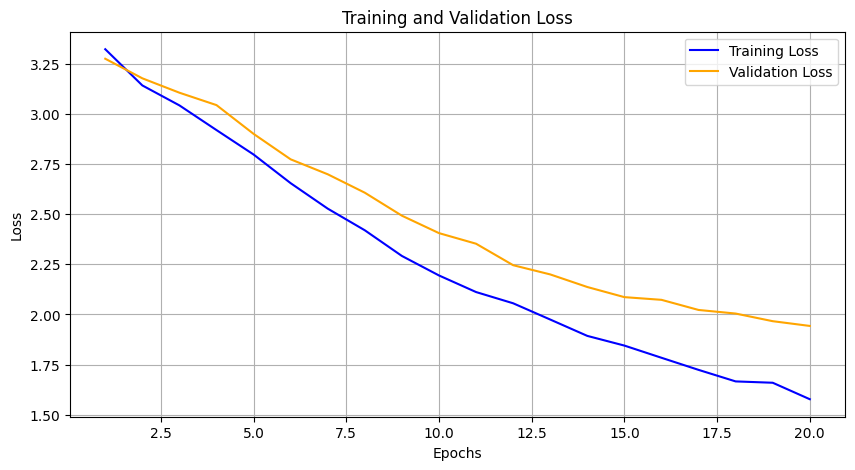

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import pandas as pd
import matplotlib.pyplot as plt
import os

# Check if CUDA is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Load the pre-trained GoogleNet (Inception v1) model
model = models.googlenet(pretrained=True)  # GoogleNet is available in torchvision

# Freeze all layers except the final fully connected layer
for param in model.parameters():
    param.requires_grad = False  # Freeze all layers
num_classes = 28
model.fc = nn.Linear(model.fc.in_features, num_classes)  # Replace the final layer with 28 classes

# Move the model to the GPU
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Suitable for multi-class classification
optimizer = iAdam(model.parameters(), lr=0.001)  # Adam optimizer

num_epochs = 20
train_loss_list = []  # To store training loss
val_loss_list = []    # To store validation loss
best_val_loss = float('inf')  # Initialize with infinity to track the best validation loss
best_model_path = "GoogleNetbest_model.pth"  # File to store the best model

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_train_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        # Move images and labels to GPU
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()  # Clear gradients
        loss.backward()        # Backpropagation
        optimizer.step()       # Update weights

        running_train_loss += loss.item()

    epoch_train_loss = running_train_loss / len(train_loader)
    train_loss_list.append((epoch + 1, epoch_train_loss))  # Store epoch number and training loss
    print(f'Epoch {epoch+1} finished, Train Loss: {epoch_train_loss:.4f}')

    # Validation phase
    model.eval()
    running_val_loss = 0.0

    with torch.no_grad():
        for images, labels in valid_loader:  # Use your validation loader
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

    epoch_val_loss = running_val_loss / len(valid_loader)
    val_loss_list.append((epoch + 1, epoch_val_loss))  # Store epoch number and validation loss
    print(f'Epoch {epoch+1} finished, Validation Loss: {epoch_val_loss:.4f}')

    # Save the model if it has the best validation loss so far
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model.state_dict(), best_model_path)  # Save the model's state dictionary
        print(f"Best model saved with validation loss: {best_val_loss:.4f}")

# Combine and save losses to a CSV file
loss_data = [(epoch, train_loss, val_loss) for (epoch, train_loss), (_, val_loss) in zip(train_loss_list, val_loss_list)]
df = pd.DataFrame(loss_data, columns=['Epoch', 'Train Loss', 'Validation Loss'])
df.to_csv('lossesGoogleNet.csv', index=False)

print("Losses saved to 'losses.csv'.")

# Plotting the losses
epochs = [epoch for epoch, _ in train_loss_list]
train_losses = [loss for _, loss in train_loss_list]
val_losses = [loss for _, loss in val_loss_list]

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss', color='blue')
plt.plot(epochs, val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.savefig('loss_plotGoogleNet.png')  # Save the plot as a PNG file
plt.show()  # Display the plot


# **GoogleNet Testing**

In [ ]:
import torch
import numpy as np
from sklearn.metrics import average_precision_score
from tqdm import tqdm

# Function to calculate mAP (mean Average Precision)
def calculate_map(all_labels, all_scores, num_classes):
    mAP_scores = []
    for c in range(num_classes):
        true_labels = (all_labels == c).astype(int)
        pred_scores = all_scores[:, c]  # Scores for class c

        # Handle case where there are no positive samples
        if true_labels.sum() == 0:
            mAP_scores.append(0.0)
            continue

        ap = average_precision_score(true_labels, pred_scores)
        mAP_scores.append(ap)

    mAP = np.mean(mAP_scores)
    return mAP

# Function to evaluate the model
def evaluate_model(model, test_loader, num_classes, model_path=None):
    # Load the best model if the path is provided
    if model_path is not None:
        print(f"Loading the best model from {model_path}")
        model.load_state_dict(torch.load(model_path))
        model = model.to(device)

    model.eval()  # Set model to evaluation mode
    top1_correct = 0
    top5_correct = 0
    total = 0
    all_labels = []
    all_preds = []
    all_scores = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images = images.to(device)  # Move images to the GPU
            labels = labels.to(device)  # Move labels to the GPU

            outputs = model(images)  # Forward pass

            # Get predicted class probabilities
            pred_scores = torch.softmax(outputs, dim=1)  # Shape: (batch_size, num_classes)

            # Get class predictions
            _, predicted = torch.max(outputs, 1)  # Shape: (batch_size,)

            # Top-1 accuracy
            top1_correct += (predicted == labels).sum().item()
            # Top-5 accuracy
            _, top5_pred = torch.topk(outputs, 5, dim=1)
            top5_correct += (top5_pred == labels.view(-1, 1).expand_as(top5_pred)).sum().item()

            total += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_scores.append(pred_scores.cpu().numpy())  # Append the scores

    # Calculate accuracies
    top1_accuracy = (top1_correct / total) * 100
    top5_accuracy = (top5_correct / total) * 100

    # Concatenate all predicted scores into a 2D array
    all_scores = np.concatenate(all_scores)  # Shape: (num_samples, num_classes)

    # Calculate mean Average Precision (mAP)
    mAP = calculate_map(np.array(all_labels), all_scores, num_classes)

    print(f'Top-1 Accuracy: {top1_accuracy:.4f}')
    print(f'Top-5 Accuracy: {top5_accuracy:.4f}')
    print(f'mAP: {mAP:.4f}')

    return {
        'Top-1 Accuracy': top1_accuracy,
        'Top-5 Accuracy': top5_accuracy,
        'mAP': mAP,
    }

# Example usage
best_model_path = 'GoogleNetbest_model.pth'  # Path where the best model is saved
results = evaluate_model(model, test_loader, num_classes=28, model_path=best_model_path)

# Print evaluation results
for metric, value in results.items():
    print(f'{metric}: {value:.4f}')


<ipython-input-33-722917031254>:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Loading the best model from GoogleNetbest_model.pth


100%|██████████| 11/11 [00:02<00:00,  5.32it/s]

Top-1 Accuracy: 50.7042
Top-5 Accuracy: 82.1596
mAP: 0.5483
Top-1 Accuracy: 50.7042
Top-5 Accuracy: 82.1596
mAP: 0.5483


# **EffiecientNet Training**

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1 finished, Train Loss: 3.4064
Epoch 1 finished, Validation Loss: 3.3078
Best model saved with validation loss: 3.3078
Epoch 2 finished, Train Loss: 3.2360
Epoch 2 finished, Validation Loss: 3.2029
Best model saved with validation loss: 3.2029
Epoch 3 finished, Train Loss: 3.0175
Epoch 3 finished, Validation Loss: 3.0372
Best model saved with validation loss: 3.0372
Epoch 4 finished, Train Loss: 2.8600
Epoch 4 finished, Validation Loss: 2.9110
Best model saved with validation loss: 2.9110
Epoch 5 finished, Train Loss: 2.6794
Epoch 5 finished, Validation Loss: 2.7934
Best model saved with validation loss: 2.7934
Epoch 6 finished, Train Loss: 2.4831
Epoch 6 finished, Validation Loss: 2.6665
Best model saved with validation loss: 2.6665
Epoch 7 finished, Train Loss: 2.3871
Epoch 7 finished, Validation Loss: 2.6003
Best model saved with validation loss: 2.6003
Epoch 8 finished, Train Loss: 2.2158
Epoch 8 finished, Validation Loss: 2.4767
Best model saved with validation loss: 2.4767


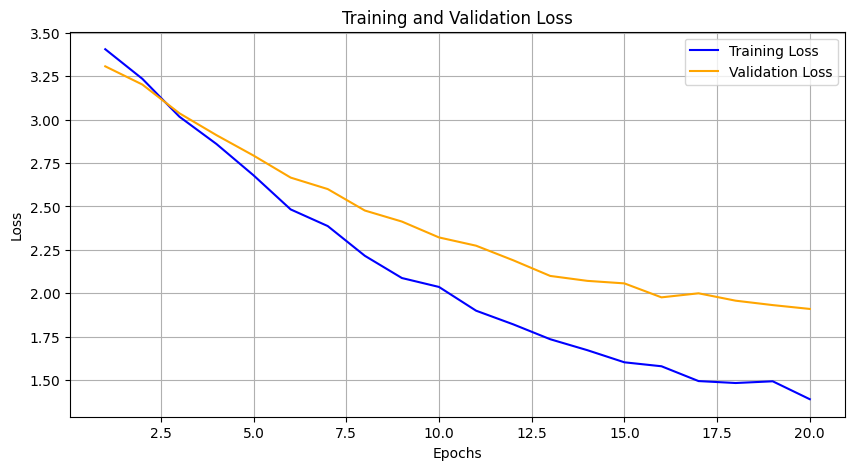

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import pandas as pd
import matplotlib.pyplot as plt
import os

# Check if CUDA is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the pre-trained EfficientNet model (EfficientNet-B0 is used here)
model = models.efficientnet_b0(pretrained=True)  # Use efficientnet_b0 to efficientnet_b7 for different sizes

# Freeze all layers except the final fully connected layer
for param in model.parameters():
    param.requires_grad = False  # Freeze all layers

# Modify the final fully connected layer for 28 output classes
num_classes = 28
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)  # Replace the classifier

# Move the model to the GPU
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Suitable for multi-class classification
optimizer = iAdam(model.parameters(), lr=0.001)  # Adam optimizer

num_epochs = 20
train_loss_list = []  # To store training loss
val_loss_list = []    # To store validation loss
best_val_loss = float('inf')  # Initialize with infinity to track the best validation loss
best_model_path = "EfficientNetbest_model.pth"  # File to store the best model

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_train_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        # Move images and labels to GPU
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()  # Clear gradients
        loss.backward()        # Backpropagation
        optimizer.step()       # Update weights

        running_train_loss += loss.item()

    epoch_train_loss = running_train_loss / len(train_loader)
    train_loss_list.append((epoch + 1, epoch_train_loss))  # Store epoch number and training loss
    print(f'Epoch {epoch+1} finished, Train Loss: {epoch_train_loss:.4f}')

    # Validation phase
    model.eval()
    running_val_loss = 0.0

    with torch.no_grad():
        for images, labels in valid_loader:  # Use your validation loader
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

    epoch_val_loss = running_val_loss / len(valid_loader)
    val_loss_list.append((epoch + 1, epoch_val_loss))  # Store epoch number and validation loss
    print(f'Epoch {epoch+1} finished, Validation Loss: {epoch_val_loss:.4f}')

    # Save the model if it has the best validation loss so far
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model.state_dict(), best_model_path)  # Save the model's state dictionary
        print(f"Best model saved with validation loss: {best_val_loss:.4f}")

# Combine and save losses to a CSV file
loss_data = [(epoch, train_loss, val_loss) for (epoch, train_loss), (_, val_loss) in zip(train_loss_list, val_loss_list)]
df = pd.DataFrame(loss_data, columns=['Epoch', 'Train Loss', 'Validation Loss'])
df.to_csv('lossesEfficientNet.csv', index=False)

print("Losses saved to 'losses.csv'.")

# Plotting the losses
epochs = [epoch for epoch, _ in train_loss_list]
train_losses = [loss for _, loss in train_loss_list]
val_losses = [loss for _, loss in val_loss_list]

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss', color='blue')
plt.plot(epochs, val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.savefig('loss_plotENet.png')  # Save the plot as a PNG file
plt.show()  # Display the plot


# **EffiecientNet Testing**

In [ ]:
import torch
import numpy as np
from sklearn.metrics import average_precision_score
from tqdm import tqdm

# Function to calculate mAP (mean Average Precision)
def calculate_map(all_labels, all_scores, num_classes):
    mAP_scores = []
    for c in range(num_classes):
        true_labels = (all_labels == c).astype(int)
        pred_scores = all_scores[:, c]  # Scores for class c

        # Handle case where there are no positive samples
        if true_labels.sum() == 0:
            mAP_scores.append(0.0)
            continue

        ap = average_precision_score(true_labels, pred_scores)
        mAP_scores.append(ap)

    mAP = np.mean(mAP_scores)
    return mAP

# Function to evaluate the model
def evaluate_model(model, test_loader, num_classes, model_path=None):
    # Load the best model if the path is provided
    if model_path is not None:
        print(f"Loading the best model from {model_path}")
        model.load_state_dict(torch.load(model_path))
        model = model.to(device)

    model.eval()  # Set model to evaluation mode
    top1_correct = 0
    top5_correct = 0
    total = 0
    all_labels = []
    all_preds = []
    all_scores = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images = images.to(device)  # Move images to the GPU
            labels = labels.to(device)  # Move labels to the GPU

            outputs = model(images)  # Forward pass

            # Get predicted class probabilities
            pred_scores = torch.softmax(outputs, dim=1)  # Shape: (batch_size, num_classes)

            # Get class predictions
            _, predicted = torch.max(outputs, 1)  # Shape: (batch_size,)

            # Top-1 accuracy
            top1_correct += (predicted == labels).sum().item()
            # Top-5 accuracy
            _, top5_pred = torch.topk(outputs, 5, dim=1)
            top5_correct += (top5_pred == labels.view(-1, 1).expand_as(top5_pred)).sum().item()

            total += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_scores.append(pred_scores.cpu().numpy())  # Append the scores

    # Calculate accuracies
    top1_accuracy = (top1_correct / total) * 100
    top5_accuracy = (top5_correct / total) * 100

    # Concatenate all predicted scores into a 2D array
    all_scores = np.concatenate(all_scores)  # Shape: (num_samples, num_classes)

    # Calculate mean Average Precision (mAP)
    mAP = calculate_map(np.array(all_labels), all_scores, num_classes)

    print(f'Top-1 Accuracy: {top1_accuracy:.4f}')
    print(f'Top-5 Accuracy: {top5_accuracy:.4f}')
    print(f'mAP: {mAP:.4f}')

    return {
        'Top-1 Accuracy': top1_accuracy,
        'Top-5 Accuracy': top5_accuracy,
        'mAP': mAP,
    }

# Example usage
best_model_path = 'EfficientNetbest_model.pth'  # Path where the best model is saved
results = evaluate_model(model, test_loader, num_classes=28, model_path=best_model_path)

# Print evaluation results
for metric, value in results.items():
    print(f'{metric}: {value:.4f}')


<ipython-input-35-53f674ed84d5>:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Loading the best model from EfficientNetbest_model.pth


100%|██████████| 11/11 [00:01<00:00,  6.47it/s]

Top-1 Accuracy: 57.2770
Top-5 Accuracy: 91.0798
mAP: 0.6563
Top-1 Accuracy: 57.2770
Top-5 Accuracy: 91.0798
mAP: 0.6563


# **DenseNet Training**

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1 finished, Train Loss: 3.3872
Epoch 1 finished, Validation Loss: 3.3567
Best model saved with validation loss: 3.3567
Epoch 2 finished, Train Loss: 3.1143
Epoch 2 finished, Validation Loss: 3.1481
Best model saved with validation loss: 3.1481
Epoch 3 finished, Train Loss: 2.9021
Epoch 3 finished, Validation Loss: 2.9806
Best model saved with validation loss: 2.9806
Epoch 4 finished, Train Loss: 2.7194
Epoch 4 finished, Validation Loss: 2.7869
Best model saved with validation loss: 2.7869
Epoch 5 finished, Train Loss: 2.4800
Epoch 5 finished, Validation Loss: 2.6197
Best model saved with validation loss: 2.6197
Epoch 6 finished, Train Loss: 2.3022
Epoch 6 finished, Validation Loss: 2.4395
Best model saved with validation loss: 2.4395
Epoch 7 finished, Train Loss: 2.1062
Epoch 7 finished, Validation Loss: 2.2775
Best model saved with validation loss: 2.2775
Epoch 8 finished, Train Loss: 1.9143
Epoch 8 finished, Validation Loss: 2.1202
Best model saved with validation loss: 2.1202


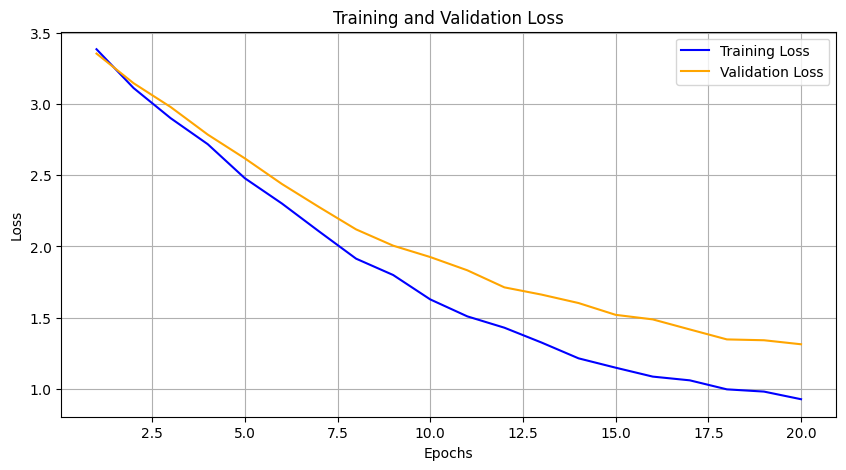

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import pandas as pd
import matplotlib.pyplot as plt
import os

# Check if CUDA is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the pre-trained DenseNet model (DenseNet121 is used here)
model = models.densenet121(pretrained=True)  # You can also use densenet169, densenet201

# Freeze all layers except the final fully connected layer
for param in model.parameters():
    param.requires_grad = False  # Freeze all layers

# Modify the final fully connected layer for 28 output classes
num_classes = 28
model.classifier = nn.Linear(model.classifier.in_features, num_classes)  # Replace the classifier

# Move the model to the GPU
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Suitable for multi-class classification
optimizer = iAdam(model.parameters(), lr=0.001)  # Adam optimizer

num_epochs = 20
train_loss_list = []  # To store training loss
val_loss_list = []    # To store validation loss
best_val_loss = float('inf')  # Initialize with infinity to track the best validation loss
best_model_path = "DenseNetbest_model.pth"  # File to store the best model

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_train_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        # Move images and labels to GPU
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()  # Clear gradients
        loss.backward()        # Backpropagation
        optimizer.step()       # Update weights

        running_train_loss += loss.item()

    epoch_train_loss = running_train_loss / len(train_loader)
    train_loss_list.append((epoch + 1, epoch_train_loss))  # Store epoch number and training loss
    print(f'Epoch {epoch+1} finished, Train Loss: {epoch_train_loss:.4f}')

    # Validation phase
    model.eval()
    running_val_loss = 0.0

    with torch.no_grad():
        for images, labels in valid_loader:  # Use your validation loader
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

    epoch_val_loss = running_val_loss / len(valid_loader)
    val_loss_list.append((epoch + 1, epoch_val_loss))  # Store epoch number and validation loss
    print(f'Epoch {epoch+1} finished, Validation Loss: {epoch_val_loss:.4f}')

    # Save the model if it has the best validation loss so far
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model.state_dict(), best_model_path)  # Save the model's state dictionary
        print(f"Best model saved with validation loss: {best_val_loss:.4f}")

# Combine and save losses to a CSV file
loss_data = [(epoch, train_loss, val_loss) for (epoch, train_loss), (_, val_loss) in zip(train_loss_list, val_loss_list)]
df = pd.DataFrame(loss_data, columns=['Epoch', 'Train Loss', 'Validation Loss'])
df.to_csv('lossesDenseNet.csv', index=False)

print("Losses saved to 'losses.csv'.")

# Plotting the losses
epochs = [epoch for epoch, _ in train_loss_list]
train_losses = [loss for _, loss in train_loss_list]
val_losses = [loss for _, loss in val_loss_list]

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss', color='blue')
plt.plot(epochs, val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.savefig('loss_plotDense.png')  # Save the plot as a PNG file
plt.show()  # Display the plot


# **DenseNet Testing**

In [ ]:
import torch
import numpy as np
from sklearn.metrics import average_precision_score
from tqdm import tqdm

# Function to calculate mAP (mean Average Precision)
def calculate_map(all_labels, all_scores, num_classes):
    mAP_scores = []
    for c in range(num_classes):
        true_labels = (all_labels == c).astype(int)
        pred_scores = all_scores[:, c]  # Scores for class c

        # Handle case where there are no positive samples
        if true_labels.sum() == 0:
            mAP_scores.append(0.0)
            continue

        ap = average_precision_score(true_labels, pred_scores)
        mAP_scores.append(ap)

    mAP = np.mean(mAP_scores)
    return mAP

# Function to evaluate the model
def evaluate_model(model, test_loader, num_classes, model_path=None):
    # Load the best model if the path is provided
    if model_path is not None:
        print(f"Loading the best model from {model_path}")
        model.load_state_dict(torch.load(model_path))
        model = model.to(device)

    model.eval()  # Set model to evaluation mode
    top1_correct = 0
    top5_correct = 0
    total = 0
    all_labels = []
    all_preds = []
    all_scores = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images = images.to(device)  # Move images to the GPU
            labels = labels.to(device)  # Move labels to the GPU

            outputs = model(images)  # Forward pass

            # Get predicted class probabilities
            pred_scores = torch.softmax(outputs, dim=1)  # Shape: (batch_size, num_classes)

            # Get class predictions
            _, predicted = torch.max(outputs, 1)  # Shape: (batch_size,)

            # Top-1 accuracy
            top1_correct += (predicted == labels).sum().item()
            # Top-5 accuracy
            _, top5_pred = torch.topk(outputs, 5, dim=1)
            top5_correct += (top5_pred == labels.view(-1, 1).expand_as(top5_pred)).sum().item()

            total += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_scores.append(pred_scores.cpu().numpy())  # Append the scores

    # Calculate accuracies
    top1_accuracy = (top1_correct / total) * 100
    top5_accuracy = (top5_correct / total) * 100

    # Concatenate all predicted scores into a 2D array
    all_scores = np.concatenate(all_scores)  # Shape: (num_samples, num_classes)

    # Calculate mean Average Precision (mAP)
    mAP = calculate_map(np.array(all_labels), all_scores, num_classes)

    print(f'Top-1 Accuracy: {top1_accuracy:.4f}')
    print(f'Top-5 Accuracy: {top5_accuracy:.4f}')
    print(f'mAP: {mAP:.4f}')

    return {
        'Top-1 Accuracy': top1_accuracy,
        'Top-5 Accuracy': top5_accuracy,
        'mAP': mAP,
    }

# Example usage
best_model_path = 'DenseNetbest_model.pth'  # Path where the best model is saved
results = evaluate_model(model, test_loader, num_classes=28, model_path=best_model_path)

# Print evaluation results
for metric, value in results.items():
    print(f'{metric}: {value:.4f}')


<ipython-input-37-cba570abb92d>:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Loading the best model from DenseNetbest_model.pth


100%|██████████| 11/11 [00:01<00:00,  6.21it/s]

Top-1 Accuracy: 69.0141
Top-5 Accuracy: 93.8967
mAP: 0.7885
Top-1 Accuracy: 69.0141
Top-5 Accuracy: 93.8967
mAP: 0.7885


# **VIT **

Epoch 1 finished, Train Loss: 3.9727
Epoch 1 finished, Validation Loss: 3.7884
Best model saved with validation loss: 3.7884
Epoch 2 finished, Train Loss: 3.7236
Epoch 2 finished, Validation Loss: 3.6390
Best model saved with validation loss: 3.6390
Epoch 3 finished, Train Loss: 3.5094
Epoch 3 finished, Validation Loss: 3.4897
Best model saved with validation loss: 3.4897
Epoch 4 finished, Train Loss: 3.2896
Epoch 4 finished, Validation Loss: 3.3096
Best model saved with validation loss: 3.3096
Epoch 5 finished, Train Loss: 3.0611
Epoch 5 finished, Validation Loss: 3.0948
Best model saved with validation loss: 3.0948
Epoch 6 finished, Train Loss: 2.8402
Epoch 6 finished, Validation Loss: 2.9015
Best model saved with validation loss: 2.9015
Epoch 7 finished, Train Loss: 2.5958
Epoch 7 finished, Validation Loss: 2.6945
Best model saved with validation loss: 2.6945
Epoch 8 finished, Train Loss: 2.3755
Epoch 8 finished, Validation Loss: 2.5495
Best model saved with validation loss: 2.5495


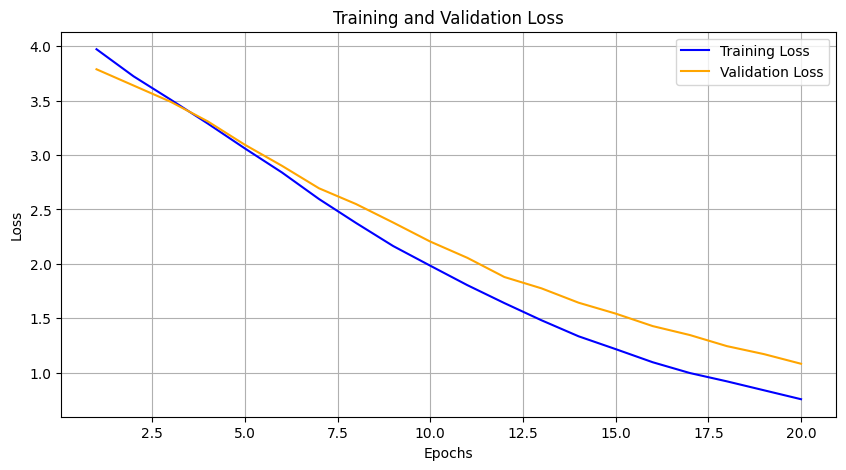

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import pandas as pd
import matplotlib.pyplot as plt
import os
import timm



# Load the pre-trained ViT model (vit_base_patch16_224)
model = timm.create_model('vit_base_patch16_224', pretrained=True)

# Freeze all parameters except the final classification head
for param in model.parameters():
    param.requires_grad = False  # Freeze all layers

# Modify the final classification layer for 28 classes
model.head = nn.Linear(model.head.in_features, 47)

# Move the model to the GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)



# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Suitable for multi-class classification
optimizer = iAdam(model.parameters(), lr=0.001)  # Adam optimizer

num_epochs = 20
train_loss_list = []  # To store training loss
val_loss_list = []    # To store validation loss
best_val_loss = float('inf')  # Initialize with infinity to track the best validation loss
best_model_path = "DenseNetbest_model.pth"  # File to store the best model

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_train_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        # Move images and labels to GPU
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()  # Clear gradients
        loss.backward()        # Backpropagation
        optimizer.step()       # Update weights

        running_train_loss += loss.item()

    epoch_train_loss = running_train_loss / len(train_loader)
    train_loss_list.append((epoch + 1, epoch_train_loss))  # Store epoch number and training loss
    print(f'Epoch {epoch+1} finished, Train Loss: {epoch_train_loss:.4f}')

    # Validation phase
    model.eval()
    running_val_loss = 0.0

    with torch.no_grad():
        for images, labels in valid_loader:  # Use your validation loader
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

    epoch_val_loss = running_val_loss / len(valid_loader)
    val_loss_list.append((epoch + 1, epoch_val_loss))  # Store epoch number and validation loss
    print(f'Epoch {epoch+1} finished, Validation Loss: {epoch_val_loss:.4f}')

    # Save the model if it has the best validation loss so far
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model.state_dict(), best_model_path)  # Save the model's state dictionary
        print(f"Best model saved with validation loss: {best_val_loss:.4f}")

# Combine and save losses to a CSV file
loss_data = [(epoch, train_loss, val_loss) for (epoch, train_loss), (_, val_loss) in zip(train_loss_list, val_loss_list)]
df = pd.DataFrame(loss_data, columns=['Epoch', 'Train Loss', 'Validation Loss'])
df.to_csv('lossesvitmrcnn.csv', index=False)

print("Losses saved to 'losses.csv'.")

# Plotting the losses
epochs = [epoch for epoch, _ in train_loss_list]
train_losses = [loss for _, loss in train_loss_list]
val_losses = [loss for _, loss in val_loss_list]

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss', color='blue')
plt.plot(epochs, val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.savefig('loss_plotvitmrcnn.png')  # Save the plot as a PNG file
plt.show()  # Display the plot


## **VIT test**

In [ ]:
import torch
import numpy as np
from sklearn.metrics import average_precision_score
from tqdm import tqdm

# Function to calculate mAP (mean Average Precision)
def calculate_map(all_labels, all_scores, num_classes):
    mAP_scores = []
    for c in range(num_classes):
        true_labels = (all_labels == c).astype(int)
        pred_scores = all_scores[:, c]  # Scores for class c

        # Handle case where there are no positive samples
        if true_labels.sum() == 0:
            mAP_scores.append(0.0)
            continue

        ap = average_precision_score(true_labels, pred_scores)
        mAP_scores.append(ap)

    mAP = np.mean(mAP_scores)
    return mAP

# Function to evaluate the model
def evaluate_model(model, test_loader, num_classes, model_path=None):
    # Load the best model if the path is provided
    if model_path is not None:
        print(f"Loading the best model from {model_path}")
        model.load_state_dict(torch.load(model_path))
        model = model.to(device)

    model.eval()  # Set model to evaluation mode
    top1_correct = 0
    top5_correct = 0
    total = 0
    all_labels = []
    all_preds = []
    all_scores = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images = images.to(device)  # Move images to the GPU
            labels = labels.to(device)  # Move labels to the GPU

            outputs = model(images)  # Forward pass

            # Get predicted class probabilities
            pred_scores = torch.softmax(outputs, dim=1)  # Shape: (batch_size, num_classes)

            # Get class predictions
            _, predicted = torch.max(outputs, 1)  # Shape: (batch_size,)

            # Top-1 accuracy
            top1_correct += (predicted == labels).sum().item()
            # Top-5 accuracy
            _, top5_pred = torch.topk(outputs, 5, dim=1)
            top5_correct += (top5_pred == labels.view(-1, 1).expand_as(top5_pred)).sum().item()

            total += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_scores.append(pred_scores.cpu().numpy())  # Append the scores

    # Calculate accuracies
    top1_accuracy = (top1_correct / total) * 100
    top5_accuracy = (top5_correct / total) * 100

    # Concatenate all predicted scores into a 2D array
    all_scores = np.concatenate(all_scores)  # Shape: (num_samples, num_classes)

    # Calculate mean Average Precision (mAP)
    mAP = calculate_map(np.array(all_labels), all_scores, num_classes)

    print(f'Top-1 Accuracy: {top1_accuracy:.4f}')
    print(f'Top-5 Accuracy: {top5_accuracy:.4f}')
    print(f'mAP: {mAP:.4f}')

    return {
        'Top-1 Accuracy': top1_accuracy,
        'Top-5 Accuracy': top5_accuracy,
        'mAP': mAP,
    }

# Example usage
best_model_path = 'DenseNetbest_model.pth'  # Path where the best model is saved
results = evaluate_model(model, test_loader, num_classes=28, model_path=best_model_path)

# Print evaluation results
for metric, value in results.items():
    print(f'{metric}: {value:.4f}')


Loading the best model from DenseNetbest_model.pth


<ipython-input-63-cba570abb92d>:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
100%|██████████| 8/8 [00:03<00:00,  2.58it/s]

Top-1 Accuracy: 90.7801
Top-5 Accuracy: 99.2908
mAP: 0.9103
Top-1 Accuracy: 90.7801
Top-5 Accuracy: 99.2908
mAP: 0.9103


In [ ]:
class iiAdam(torch.optim.Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0.1, lambda_func=lambda t: 1.0):
        defaults = {'lr': lr, 'betas': betas, 'eps': eps, 'weight_decay': weight_decay, 'lambda_func': lambda_func}
        super(iiAdam, self).__init__(params, defaults)
        # Initialize state for each parameter
        for p in self.param_groups[0]['params']:
            self.state[p] = {
                'step': 0,
                'exp_avg': torch.zeros_like(p.data),
                'exp_avg_sq': torch.zeros_like(p.data),
            }

    def step(self):
        for group in self.param_groups:
            lr = group['lr']
            beta1, beta2 = group['betas']
            eps = group['eps']
            weight_decay = group['weight_decay']  # Fetch weight decay
            lambda_func = group['lambda_func']

            for p in group['params']:
                if p.grad is None:
                    continue

                state = self.state[p]
                state['step'] += 1
                exp_avg = state['exp_avg']
                exp_avg_sq = state['exp_avg_sq']

                # Calculate lambda_t and check for validity
                lambda_t = torch.tensor(lambda_func(state['step']), dtype=torch.float32)
                if torch.isnan(lambda_t) or torch.isinf(lambda_t):
                    lambda_t = torch.tensor(1.0)  # Default to 1.0 if invalid

                # Apply weight decay (L2 regularization)
                if weight_decay > 0:
                    p.grad.data.add_(weight_decay * p.data)

                # Compute the weight penalty
                weight_penalty = lambda_t * p.data * 0.000001

                # Compute the adjusted gradient
                grad = p.grad.data - exp_avg + weight_penalty
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(p.grad.data, p.grad.data, value=1 - beta2)

                # Compute bias-corrected averages
                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']

                # Compute the step size and denominator
                step_size = lr / bias_correction1
                denom = exp_avg_sq.sqrt().div(bias_correction2).add_(eps)

                # Update parameters
                p.data.addcdiv_(exp_avg, denom, value=-step_size)

                # Optionally apply gradient clipping before updating parameters
                torch.nn.utils.clip_grad_norm_([p], max_norm=1.0)
